# Homework 4. Molecular dynamics simulation  of 2D soft-disk fluid

In this homework, you will use molecular dynamics to simulate the behavior of fluid consisting of soft disks in two dimensions. The particles in this fluid interact with each other via the pairwise potential of the following form: 

 $$  u(r_{ij})=\left\{
                \begin{array}{ll}
                  4\epsilon \left[ 
                  \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{12} 
                  -
                   \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{6} + 
                  \right ] + \epsilon,  \ r_{ij} < r_c\\
                  0, r_{ij} \geq r_c, r_c = 2^{1/6}\sigma
                \end{array}
              \right.
$$

For this model, we will use reduced MD units, such that $\sigma = 1 $, $  \epsilon=1$,  $k_b = 1$.
All the particles have unit mass.

$ r_c = 2^{1/6}\sigma $

**The homework consists of 5 tasks, 25 points total. You should work in groups of 3-4 people and submit one solution for each group within 3 weeks. You can use GitHub for collaboration.**

## Task 1.  System initialization

1) Write a function that assigns coordinates of  N particles on a square grid inside a square box with side length L. This function should return a 2d array with coordinates for each particle. (1 pt)

2) Write a function that takes temperature as input and initializes particle velocities consistent with the given temperature. Make sure that the total momentum of the system is zero. (2 pt)


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# reduced MD units
epsilon, m, kb, sigma = 1, 1, 1, 1

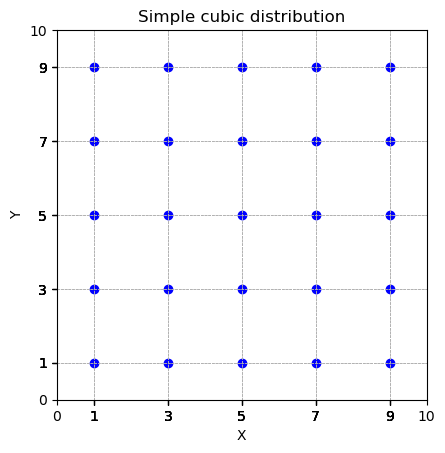

In [3]:
# This is a function which initialises the system
# INPUTS: Temperature (T), Length of the box (L), Number of particles (N)
# OUTPUTS: 
# x_matrix (N,2) for the positions, where the first column contanins the x-coordinates and the second the y-coordinates
# v_matrix (N,2) for the velocities, where the first column contanins the vx-coordinates and the second the vy-coordinates

# We define the inputs:
N=25 # The square root of N (total number of particles) should be an integer
L=10 # Length of the box
T=1 # Temperature (K)

def initialise_system(T, N, L):
    # assert that N is a square number
    assert N == math.isqrt(N) ** 2, "N should be a square number"
    # initialise positions
    d=L/N**0.5
    x = np.arange(d/2, L, d)  
    X, Y = np.meshgrid(x, x)
    r0_matrix = np.column_stack((X.flatten(),Y.flatten()))
    # initialise velocities
    v = np.sqrt(kb*T/m) * np.random.randn(N,2)
    p = np.sum(v*m, axis=0)
    v0_matrix=v-(p/(m*N))
    return r0_matrix, v0_matrix

r0_matrix, v0_matrix = initialise_system(T, N, L)

# Plot the points
plt.scatter(r0_matrix[:,0], r0_matrix[:,1], marker='o', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simple cubic distribution')
box_limits=np.array([0, L])
xlimits = np.around(np.append(r0_matrix[:,0], box_limits), decimals=1)
ylimits = np.around(np.append(r0_matrix[:,1], box_limits), decimals=1)
plt.xticks(xlimits)
plt.yticks(ylimits)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,L)
plt.ylim(0,L)

plt.show()

## Task 2. Building MD code  


1) Write code to perform molecular dynamics simulation of your system according to the following algorithm:

 *  Initialize positions, velocities, and accelerations for your system.
 * For each modeling step:
      - Update coordinates using velocity Verlet algorithm. (1 pt)
      - Apply periodic boundary conditions to coordinates. (1pt)
      - Calculate the force acting on each particle and accelerations. Keep in mind minimum image convention! (4 pt)
      - Update velocities using velocity Verlet algorithm. (1pt)

In [4]:
def apply_pbc(L, r):
    """ L is length of box
        r is an (N,2) matrix
    """
    # I assumed here our box is from [0, L) instead of [-L/2, L/2) as we had before as I think that's how we initialised it 
    return r%L

    # if we want to do [-L/2, L/2) I think we can use this
    #def apply_pbc(L, r):
        #return (r + L/2)%L - L/2

In [5]:
def calculate_distances_vectors(r, N, L):
    distances = np.zeros((N,N))
    vectors = np.zeros((N,N,2))
    for i in range(N-1):
        for j in range(i+1, N):
            r_ij = r[j, :] - r[i, :]
            r_ij = r_ij - L * np.rint(r_ij / L)
            vectors[i, j] = r_ij
            vectors[j, i] = -r_ij
            min_dist = np.linalg.norm(r_ij)
            distances[i, j] = min_dist
            distances[j, i] = min_dist
    return distances, vectors

In [6]:
def f_lj(r, epsilon, sigma):
    F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))    
    return F

def f_lj_shifted_with_cutoff(r, sigma, epsilon):
    """
    LJ force resulting from potential shifted up by epsilon
    and truncated at r=sigma* 2^(1/6)
    """
    distances, vectors = calculate_distances_vectors(r, N, L)
    distances = np.expand_dims(distances, axis=-1)
    norm_vectors = vectors / distances
    norm_vectors = np.nan_to_num(norm_vectors, copy=True, nan=0.0)
    r_c = sigma*np.power(2, 1/6)
    force_magnitudes = np.zeros(distances.shape)
    forces = np.zeros(r.shape)
    r_below_c = np.argwhere(distances < r_c)
    force_magnitudes[r_below_c] = f_lj(distances[r_below_c], sigma, epsilon)
    force_magnitudes = np.nan_to_num(force_magnitudes, copy=True, nan=0.0)
    forces = force_magnitudes * norm_vectors
    forces = forces.sum(axis=1)
    return forces

In [7]:
def velocity_verlet_integration(N, dt, nsteps, force, **kwargs):
    """
    Velocity Verlet integration
    """
    #1.update velocity halfway
    #2.update position using the intermediate velocity 
    #3.update velocity based on the updated position
    coordinates_verlet = np.zeros((nsteps,N,2))
    velocities_verlet = np.zeros((nsteps,N,2))

    # Initialisation 
    coordinates_verlet[0], velocities_verlet[0] = initialise_system(T,N,L)

    # calculate initial force once here, then rest will be recycled in each loop below  
    f1 = force(coordinates_verlet[0], epsilon, sigma)

    for i in range(nsteps-1):
        v_halfway = velocities_verlet[i] + 0.5*dt*f1 #1. velocity update    
        r_current = coordinates_verlet[i] + v_halfway*dt #2. update position using intermediate velocity
        # apply pbcs
        coordinates_verlet[i+1] = apply_pbc(L, r_current)
        f2 = force(coordinates_verlet[i+1], epsilon, sigma)
        velocities_verlet[i+1] = v_halfway + 0.5*dt*f2 #3.update velocity based on the updated position       
        # store force for next loop
        f1 = f2      
       
    return coordinates_verlet, velocities_verlet

In [8]:
dt=0.1
nsteps=100
coordinates_verlet, velocities_verlet = velocity_verlet_integration(N, dt, nsteps, f_lj_shifted_with_cutoff)

C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:12: RuntimeWarning: invalid value encountered in true_divide
  norm_vectors = vectors / distances
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:2: RuntimeWarning: divide by zero encountered in true_divide
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:2: RuntimeWarning: invalid value encountered in add
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))


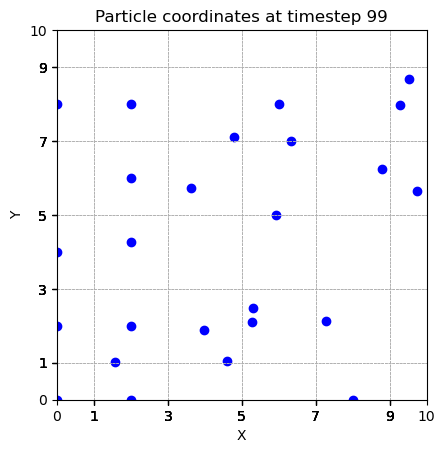

In [9]:
# Plot the points
timestep = 99
plt.scatter(coordinates_verlet[timestep,:,0], coordinates_verlet[timestep,:,1], marker='o', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Particle coordinates at timestep {timestep}')

box_limits=np.array([0, L])
xlimits = np.around(np.append(r0_matrix[:,0], box_limits), decimals=1)
ylimits = np.around(np.append(r0_matrix[:,1], box_limits), decimals=1)

plt.xticks(xlimits)
plt.yticks(ylimits)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(0,L)
plt.ylim(0,L)

plt.show()

## Task 3. Simulations in the microcanonical ensemble

1) Use the code you wrote in task 3 to run MD simulation of a system with 49 particles in a square box with side length L = 7 for at least 5000 steps. Initialize velocities using T=1. Use integration step dt = 0.005. Save coordinates and velocities at each step to a file. (2 pt)

2) For each timestep, calculate and plot the following values as a function of time: $\sum_i^{N particles} V_x^i $, $\sum_y^{N particles} V_y^i $, $E_{total}$, $E_{potential}$, $E_{kinetic}$, temperature. Which of the these values should be conserved? Do your results match the prediction?  (3 pt)

3) Was the modeling time enough for the system to equilibrate? Explain.  (1 pt)


In [41]:
# 1)
# Constants
N = 49 
L = 7   # Box side length
T = 1   # Temperature (K)
dt = 0.005  # Integration step

# Perform MD simulation
nsteps = 5000  # Number of steps
coordinates_2, velocities_2 = velocity_verlet_integration(N, dt, nsteps, f_lj_shifted_with_cutoff)

# Save coordinates and velocities to a file
np.savez('md_simulation_output.npz', coordinates=coordinates_2, velocities=velocities_2)

C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:12: RuntimeWarning: invalid value encountered in true_divide
  norm_vectors = vectors / distances
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:2: RuntimeWarning: divide by zero encountered in true_divide
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:2: RuntimeWarning: invalid value encountered in add
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))


In [42]:
# Load the .npz file
#data = np.load('md_simulation_output.npz')

# Display keys in the NPZ file
#print("Keys in the file:", data.files)

# Access individual arrays within the .npz file
#coordinates_verlet = data['coordinates']  
#velocities_verlet = data['velocities'] 

#print(f"Coordinates: {coordinates_verlet} /n Velocities: {velocities_verlet}")

C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\4009096291.py:8: RuntimeWarning: divide by zero encountered in true_divide
  u = 4*epsilon*(np.power(sigma/r, 12)-np.power(sigma/r, 6))
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\4009096291.py:8: RuntimeWarning: invalid value encountered in subtract
  u = 4*epsilon*(np.power(sigma/r, 12)-np.power(sigma/r, 6))


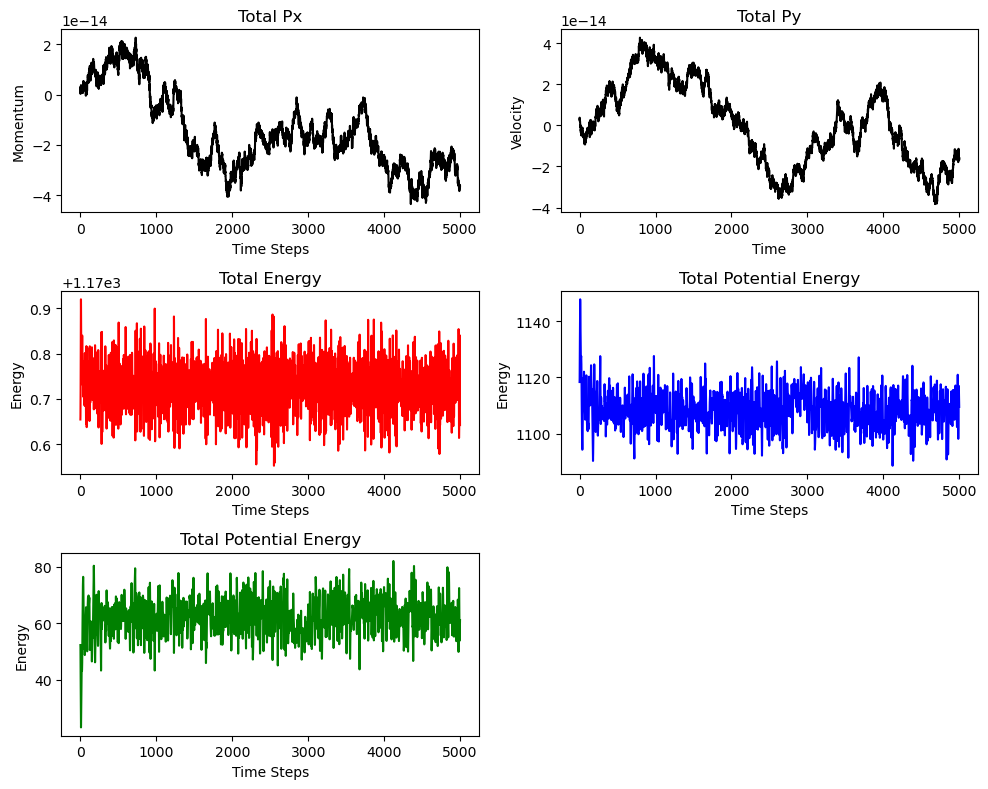

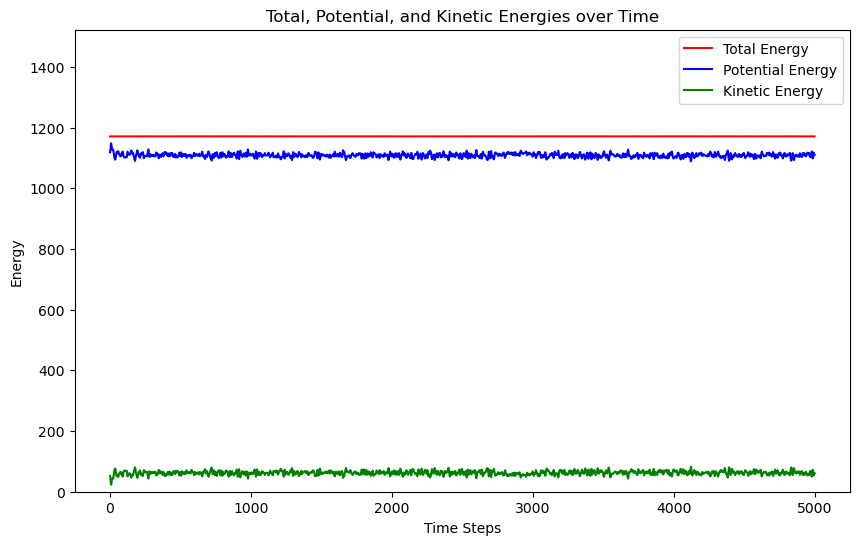

In [46]:
# Constants for your system
m = 1  # Mass of particles (assuming it's 1 for simplicity)

def u_lj(r, sigma, epsilon):
    """
    Lennard-Jones potential
    """
    u = 4*epsilon*(np.power(sigma/r, 12)-np.power(sigma/r, 6))
    return u

def u_lj_shifted_with_cutoff(r, sigma, epsilon):
    """
    LJ potential shifted up by epsilon and trancated
    at r=sigma* 2^(1/6)
    (Target potential)
    """
    r_c = sigma*np.power(2, 1/6)
    potential = np.zeros(r.shape)
    
    # Selecting positins below cutoff
    r_below_rc = np.argwhere(r < r_c)
    
    potential[r_below_rc] = u_lj(r[r_below_rc], sigma, epsilon) + epsilon
    potential=np.nan_to_num(potential, copy=True, nan=0.0) # The diagonal elements are now zero
    P=np.sum(potential, axis=1) 
    return P

# Momentum arrays
total_px = np.sum(m * velocities_2[:, :, 0], axis=1)
total_py = np.sum(m * velocities_2[:, :, 1], axis=1)

# Function to calculate potential energy using LJ potential
def calculate_potential_energy(coordinates):
    total_potential_energy = np.zeros(coordinates.shape[0])
    for i in range(coordinates.shape[0]):
        distances, _ = calculate_distances_vectors(coordinates[i], N, L)
        potential_energy = u_lj_shifted_with_cutoff(distances, sigma, epsilon)
        total_potential_energy[i] = np.sum(potential_energy) / 2
    return total_potential_energy

potential_energy = calculate_potential_energy(coordinates_2)
kinetic_energy = 0.5 * np.sum((np.linalg.norm(velocities_2, axis=1) ** 2), axis = 1)
total_energy = potential_energy + kinetic_energy

# Plot the quantities as a function of time
time_steps = np.arange(len(coordinates_2))

plt.figure(figsize=(10, 8))

plt.subplot(3, 2, 1)
plt.plot(time_steps, total_px, label='Total Px', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Momentum')
plt.title("Total Px")

plt.subplot(3, 2, 2)
plt.plot(time_steps, total_py, label='Total Py', color='black')
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Total Py")

plt.subplot(3, 2, 3)
plt.plot(time_steps, total_energy, label='Total Energy', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.title("Total Energy")

plt.subplot(3, 2, 4)
plt.plot(time_steps, potential_energy, label='Potential Energy', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.title("Total Potential Energy")

plt.subplot(3, 2, 5)
plt.plot(time_steps, kinetic_energy, label='Kinetic Energy', color='green')
plt.title("Total Potential Energy")
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.tight_layout()

plt.figure(figsize=(10, 6))

plt.plot(time_steps, total_energy, label='Total Energy', color='red')
plt.plot(time_steps, potential_energy, label='Potential Energy', color='blue')
plt.plot(time_steps, kinetic_energy, label='Kinetic Energy', color='green')

plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.title('Total, Potential, and Kinetic Energies over Time')
plt.ylim(0, max(total_energy)*1.3)

plt.legend()
plt.legend(loc='upper right')

plt.show()

## Task 4. Constant temperature molecular  dynamics

In this task, you will extend code from task 2 to run the simulation at a constant temperature using Langevin dynamics.

1) Implement integration of the Langevin equation. (2 pt)

2) Simulate cooling of the liquid with 121 particles in the box with L=11. First, run the simulation at T=1.4 for 2000 steps. Use final coordinates and velocities to start another simulation, this time with T=1.2.  Run this lower-temperature simulation for 2000 steps. Keep restarting the simulation, each time decreasing the temperature by 0.2. The final run should be performed at T=0.6  In all the simulations, use a constant friction coefficient of your choice. (2 pt)

3) Visualize several frames from a low-temperature fragment of the trajectory. These frames represent the microscopic structure of the frozen soft-disk liquid. Is the structure different from the initial square-grid arrangement? (1 pt)

In [56]:
# Integration of Langevin equation
def langevin_integration(T, N, nsteps, dt, L, force, initial_coords, initial_velocities):
    """
    Integration of Langevin equation
    """
    coordinates_langevin = np.zeros((nsteps,N,2))
    velocities_langevin = np.zeros((nsteps,N,2))

    # initialisation 
    coordinates_langevin[0], velocities_langevin[0] = initial_coords, initial_velocities

    # calculate initial force once here, then rest will be recycled in each loop below  
    f1 = force(coordinates_langevin[0], epsilon, sigma)

    for i in range(nsteps-1):
        v_halfway = velocities_langevin[i] + np.sqrt(2*kB*T*gamma/m) * np.random.normal() * 0.5*dt*f1
        r_current = coordinates_langevin[i] + v_halfway*dt
        # apply pbcs
        coordinates_langevin[i+1] = apply_pbc(L, r_current)
        f2 = force(coordinates_langevin[i+1], epsilon, sigma)
        velocities_langevin[i+1] = v_halfway + 0.5*dt*f2 * np.exp(-gamma * dt)
        # store force for next loop
        f1 = f2
    
    return coordinates_langevin, velocities_langevin

In [57]:
# Cooling of liquid
N = 121
L = 11
dt = 0.005
nsteps = 2000
Ts = np.arange(1.4, 0.5, -0.2)
kB = 1.
gamma = 1.

coordinates_langevin = np.zeros((len(Ts),nsteps,N,2))
velocities_langevin = np.zeros((len(Ts),nsteps,N,2))

ic, iv = initialise_system(Ts[0], N, L)

for i,T in enumerate(Ts):
    coordinates_langevin[i], velocities_langevin[i] = langevin_integration(T, N, nsteps, dt, L, f_lj_shifted_with_cutoff, ic, iv)
    ic = coordinates_langevin[i,-1,:,:]
    iv = velocities_langevin[i,-1,:,:]

C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:12: RuntimeWarning: invalid value encountered in true_divide
  norm_vectors = vectors / distances
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:2: RuntimeWarning: divide by zero encountered in true_divide
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))
C:\Users\ev-s3\AppData\Local\Temp\ipykernel_23300\2627903728.py:2: RuntimeWarning: invalid value encountered in add
  F=4*epsilon*(-12*(sigma**12/r**13)+6*(sigma**6/r**7))


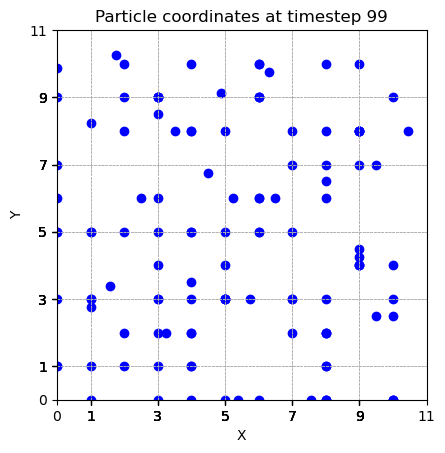

In [64]:
# Visualise low T
temp_num = 4
timestep = 99
plt.scatter(coordinates_langevin[temp_num,timestep,:,0], coordinates_langevin[temp_num,timestep,:,1], marker='o', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Particle coordinates at timestep {timestep}')

box_limits=np.array([0, L])
xlimits = np.around(np.append(r0_matrix[:,0], box_limits), decimals=1)
ylimits = np.around(np.append(r0_matrix[:,1], box_limits), decimals=1)

plt.xticks(xlimits)
plt.yticks(ylimits)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(0,L)
plt.ylim(0,L)

plt.show()

## Task 5. Considerations when modeling realistic systems

It is easy to run a simulation that yields meaningless results when doing molecular dynamics simulation. To avoid this problem, one should know the properties and limitations of the algorithms used. To prevent some of the common pitfalls in the future, answer the following questions.

1) What is the maximum cut-off radius for nonbonded interactions in a periodic system with cubic box size L?  Explain your answer. (1 pt)

2) Can the Andersen thermostat be used to study dynamic properties of the system, such as diffusion coefficients. Why? (1 pt)

3) What is the purpose of the particle mesh Ewald (PME) algorithm? Please briefly describe the method and a) why it is used, b) which caveats does it have, c) what are the alternatives (3 pt)